In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import rl_utils

# 1_Expert Data Generation with PPO-Clip

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=1)
        )
    
    def forward(self, state):
        return self.net(state)

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, state):
        return self.net(state)

In [25]:
class PPOClip:
    """ PPO-Clip algorithm """
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 actor_lr,
                 critic_lr,
                 lmbda,
                 epochs,
                 eps,
                 gamma,
                 device):
        
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
    
    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def update(self, transition_dict):
        states = torch.tensor(np.array(transition_dict['states']), dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(transition_dict['actions']), dtype=torch.int64).view(-1, 1).to(self.device)
        rewards = torch.tensor(np.array(transition_dict['rewards']), dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(np.array(transition_dict['next_states']), dtype=torch.float).to(self.device)
        dones =torch.tensor(np.array(transition_dict['dones']), dtype=torch.float).view(-1, 1).to(self.device)

        td_target = rewards + self.gamma * self.critic(next_states) * (~dones.bool()).float()
        td_error = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_error.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        for _ in range(self.epochs):
            log_prob = torch.log(self.actor(states).gather(1, actions))
            ration = torch.exp(log_prob - old_log_probs)
            surr1 = ration * advantage
            surr2 = torch.clamp(ration, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = -torch.mean(torch.min(surr1, surr2))
            critic_loss = F.mse_loss(self.critic(states), td_target.detach())
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [4]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 250
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)

seed = 0
env.reset(seed=seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
ppo_agent = PPOClip(state_dim,
                    hidden_dim,
                    action_dim,
                    actor_lr,
                    critic_lr,
                    lmbda,
                    epochs,
                    eps,
                    gamma,
                    device)


/home/user/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [5]:
return_list = rl_utils.train_on_policy_agent(env, ppo_agent, num_episodes)

Iteration 0:   0%|          | 0/25 [00:00<?, ?it/s]/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/workspace/RL-Algorithms/rl_utils.py:134: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392067780/work/torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(advantage_list, dtype=torch.float)
Iteration 9: 100%|██████████| 25/25 [00:01<00:00, 16.66it/s, episode=245, return=200.000]


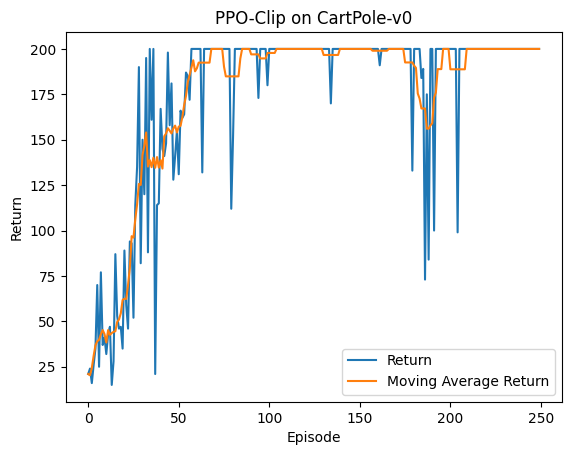

In [6]:
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(return_list, label='Return')
plt.plot(mv_return, label='Moving Average Return')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('PPO-Clip on CartPole-v0')
plt.legend()
plt.show()

In [7]:
def sample_expert_data(n_episode):
    states = []
    actions = []
    for episode in range(n_episode):
        reset_output = env.reset()
        state = reset_output[0] if isinstance(reset_output, tuple) else reset_output
        done = False
        while not done:
            action = ppo_agent.take_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            states.append(state)
            actions.append(action)
            state = next_state
    return np.array(states), np.array(actions)

In [8]:
seed = 0
env.reset(seed=seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

n_episode = 10
expert_s, expert_a = sample_expert_data(n_episode)

n_samples = 300
random_index = random.sample(range(expert_s.shape[0]), n_samples)
expert_s = expert_s[random_index]
expert_a = expert_a[random_index]

In [9]:
print(expert_s)
print(expert_a)

[[ 2.9972408e-02 -5.1468492e-01 -7.3680051e-02  1.6438712e-01]
 [-1.3313769e-01  2.4820755e-03  2.1329455e-02  2.8992524e-02]
 [-9.5338620e-02 -3.6087698e-01  4.2836036e-04  4.0715888e-01]
 ...
 [ 1.0667381e-01  2.4230650e-01 -6.1488256e-02 -4.0074861e-01]
 [-2.2425689e-02 -2.2443068e-01 -3.1389181e-02  1.2522057e-01]
 [-1.2194525e-01  4.0633947e-01  2.7309172e-02 -4.7106582e-01]]
[0 1 1 1 0 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1
 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1
 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0
 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0
 0 1 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1
 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0
 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1
 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 1
 1 0 0 1]


# 2_Behavior Cloning, BC

In [10]:
class BehaviorClone:
    def __init__(self, state_dim, hidden_dim, action_dim, lr, device):
        self.policy = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)
        self.device = device
    
    def learn(self, states, actions):
        states = torch.tensor(np.array(states), dtype=torch.float).to(self.device)
        actions = torch.tensor(np.array(actions), dtype=torch.int64).view(-1, 1).to(self.device)
        log_probs = torch.log(self.policy(states).gather(1, actions))
        bc_loss = -torch.mean(log_probs)

        self.optimizer.zero_grad()
        bc_loss.backward()
        self.optimizer.step()
    
    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.policy(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

def test_agent(agent, env, n_episode):
    return_list = []
    for episode in range(n_episode):
        episode_return = 0
        reset_output = env.reset()
        state = reset_output[0] if isinstance(reset_output, tuple) else reset_output
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_return += reward
            state = next_state
        return_list.append(episode_return)
    return np.mean(return_list)

In [11]:
seed = 0
env.reset(seed=seed)
env.action_space.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

lr = 1e-2
n_iterations = 300
batch_size = 64
test_returns = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bc_agent = BehaviorClone(state_dim, hidden_dim, action_dim, lr, device)

with tqdm(total=n_iterations, desc='iterations') as pbar:
    for i in range(n_iterations):
        sample_indices = np.random.randint(low=0, high=expert_s.shape[0], size=batch_size)
        bc_agent.learn(expert_s[sample_indices], expert_a[sample_indices])
        current_return = test_agent(bc_agent, env, 5)
        test_returns.append(current_return)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(test_returns[-10:])})
        pbar.update(1)

iterations: 100%|██████████| 300/300 [01:04<00:00,  4.65it/s, return=200.000]


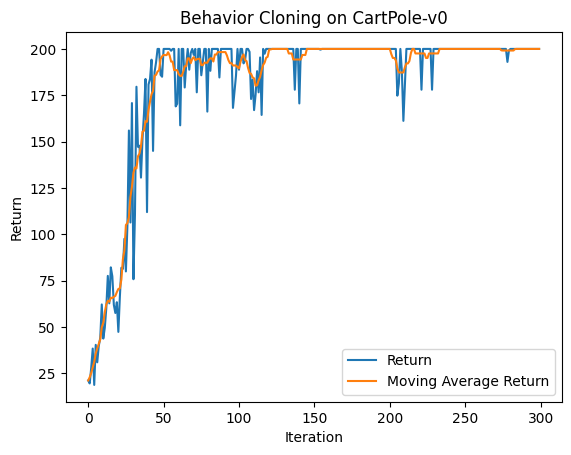

In [12]:
mv_return = rl_utils.moving_average(test_returns, 9)
plt.plot(test_returns, label='Return')
plt.plot(mv_return, label='Moving Average Return')
plt.xlabel('Iteration')
plt.ylabel('Return')
plt.title('Behavior Cloning on {}'.format(env_name))
plt.legend()
plt.show()

In [13]:
rl_utils.watch_agent(env_name, bc_agent, device, num_episodes=1)

/home/user/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [14]:
score = rl_utils.moving_average_score(test_returns)
print('Average score: %.3f' % score)

Average score: 200.000


In [19]:
rl_utils.record_multiple_episodes(env_name,
                                  bc_agent,
                                  device,
                                  num_episodes=1,
                                  videos_per_row=1,
                                  filename='bc(ppo-c)_cartpole(v0)_r1',
                                  score=score)
rl_utils.record_multiple_episodes(env_name,
                                  bc_agent,
                                  device,
                                  num_episodes=10,
                                  videos_per_row=5,
                                  filename='bc(ppo-c)_cartpole(v0)_r10',
                                  score=score)

MoviePy - Building file ./video/bc(ppo-c)_cartpole(v0)_r1_score200.00_20250504-180934.gif with imageio.


✅ Video saved at ./video/bc(ppo-c)_cartpole(v0)_r1_score200.00_20250504-180934.gif
MoviePy - Building file ./video/bc(ppo-c)_cartpole(v0)_r10_score200.00_20250504-180937.gif with imageio.


✅ Video saved at ./video/bc(ppo-c)_cartpole(v0)_r10_score200.00_20250504-180937.gif


In [18]:
agent_dict = {
    'policy': bc_agent.policy
}
rl_utils.save_all(agent_dict=agent_dict,
                  return_list=test_returns,
                  model_name='bc(ppo-c)_cartpole(v0)',
                  mv_return=mv_return,
                  score=score)

✅ Multi-agents saved at ./agent/bc(ppo-c)_cartpole(v0)_score200.00_20250504-180923.pth
📝 Save log updated at ./agent/save_log.json
✅ Return list saved at ./results/bc(ppo-c)_cartpole(v0)_score200.00_20250504-180923_return_list.pkl
📈 Return curve saved at ./results/bc(ppo-c)_cartpole(v0)_score200.00_20250504-180923_return_curve.png


# 3_Generative Adversarial Imitation Learning, GAIL

In [20]:
class Discriminator(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.net(x)

In [29]:
class GAIL:
    def __init__(self,
                 agent,
                 state_dim,
                 action_dim,
                 hidden_dim,
                 lr_d,
                 device):
        self.discriminator = Discriminator(state_dim, hidden_dim, action_dim).to(device)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr_d)
        self.agent = agent
        self.device = device
    
    def learn(self,
              expert_s,
              expert_a,
              agent_s,
              agent_a,
              next_s,
              dones):
        expert_states = torch.tensor(np.array(expert_s), dtype=torch.float).to(self.device)
        expert_actions = torch.tensor(np.array(expert_a), dtype=torch.int64).to(self.device)
        agent_states = torch.tensor(np.array(agent_s), dtype=torch.float).to(self.device)
        agent_actions = torch.tensor(np.array(agent_a), dtype=torch.int64).to(self.device)

        expert_actions = F.one_hot(expert_actions, num_classes=self.agent.action_dim).float()
        agent_actions = F.one_hot(agent_actions, num_classes=self.agent.action_dim).float()

        expert_prob = self.discriminator(expert_states, expert_actions)
        agent_prob = self.discriminator(agent_states, agent_actions)

        discriminator_loss = F.binary_cross_entropy(agent_prob, torch.ones_like(agent_prob)) + \
                            F.binary_cross_entropy(expert_prob, torch.zeros_like(expert_prob))
        self.discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        self.discriminator_optimizer.step()

        rewards = -torch.log(agent_prob).detach().cpu().numpy()
        transition_dict = {
            'states': agent_s,
            'actions': agent_a,
            'rewards': rewards,
            'next_states': next_s,
            'dones': dones
        }
        self.agent.update(transition_dict)
        

In [30]:
seed = 0
env.reset(seed=seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

lr_d = 1e-3
agent = PPOClip(state_dim,
                hidden_dim,
                action_dim,
                actor_lr,
                critic_lr,
                lmbda,
                epochs,
                eps,
                gamma,
                device)

gail = GAIL(agent,
            state_dim,
            action_dim,
            hidden_dim,
            lr_d,
            device)

n_episode = 500
return_list = []

with tqdm(total=n_episode, desc='episodes') as pbar:
    for i in range(n_episode):
        episode_return = 0
        reset_out = env.reset()
        state = reset_out[0] if isinstance(reset_out, tuple) else reset_out
        done = False

        state_list = []
        action_list = []
        next_state_list = []
        done_list = []
        while not done:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            state_list.append(state)
            action_list.append(action)
            next_state_list.append(next_state)
            done_list.append(done)

            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        gail.learn(expert_s,
                   expert_a,
                   state_list,
                   action_list,
                   next_state_list,
                   done_list)
        if (i + 1) % 10 == 0:
            pbar.set_postfix({'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)

episodes:   0%|          | 0/500 [00:00<?, ?it/s]

episodes: 100%|██████████| 500/500 [00:29<00:00, 16.73it/s, return=200.000]


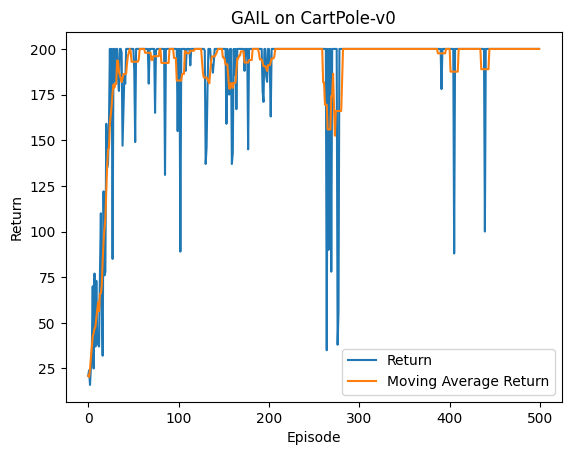

In [31]:
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(return_list, label='Return')
plt.plot(mv_return, label='Moving Average Return')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('GAIL on {}'.format(env_name))
plt.legend()
plt.show()

In [32]:
rl_utils.watch_agent(env_name, gail.agent, device, num_episodes=1)

/home/user/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [33]:
score = rl_utils.moving_average_score(return_list)
print('Average score: %.3f' % score)

Average score: 200.000


In [34]:
rl_utils.record_multiple_episodes(env_name,
                                  gail.agent,
                                  device,
                                  num_episodes=1,
                                  videos_per_row=1,
                                  filename='gail(ppo-c)_cartpole(v0)_r1',
                                  score=score)
rl_utils.record_multiple_episodes(env_name,
                                  gail.agent,
                                  device,
                                  num_episodes=10,
                                  videos_per_row=5,
                                  filename='gail(ppo-c)_cartpole(v0)_r10',
                                  score=score)

/home/user/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/user/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


MoviePy - Building file ./video/gail(ppo-c)_cartpole(v0)_r1_score200.00_20250505-013453.gif with imageio.


✅ Video saved at ./video/gail(ppo-c)_cartpole(v0)_r1_score200.00_20250505-013453.gif
MoviePy - Building file ./video/gail(ppo-c)_cartpole(v0)_r10_score200.00_20250505-013456.gif with imageio.


✅ Video saved at ./video/gail(ppo-c)_cartpole(v0)_r10_score200.00_20250505-013456.gif


In [35]:
agent_dict = {
    'actor': gail.agent.actor,
    'critic': gail.agent.critic,
    'discriminator': gail.discriminator
}
rl_utils.save_all(agent_dict=agent_dict,
                  return_list=return_list,
                  model_name='gail(ppo-c)_cartpole(v0)',
                  mv_return=mv_return,
                  score=score)

✅ Multi-agents saved at ./agent/gail(ppo-c)_cartpole(v0)_score200.00_20250505-013650.pth
📝 Save log updated at ./agent/save_log.json
✅ Return list saved at ./results/gail(ppo-c)_cartpole(v0)_score200.00_20250505-013650_return_list.pkl
📈 Return curve saved at ./results/gail(ppo-c)_cartpole(v0)_score200.00_20250505-013650_return_curve.png
